# Non Lineair Dynamics Project

In this project we explore the stability of biological communities. We will be studying the effect when we combine mutalistic and antognistic interaction between species together in one community.

More concreet we will try to reproduce the results of this paper: *A. Moughi and M. Kondoh:* Diversity of Interaction Types and Ecological Community Stability.*Science* **337**,349 (2012)

## Methodology

First some basic questions out the way:
* **Q:What exactly do we want to study?**

*A: We want to study the stability of a complex community. For this we will actually check for a given fixed set of parameters, that define the community dynamics, if it is stable or not. Doing this then many times for the same configuration we can eventually put a probability on how stable the community is under these parameters.*
* **Q:How do we even represent a community and its dynamics?**

*A: We will be working with a vector $\vec{X}$ who's components are the abundance of species, and thus represent the state of our community at a given time. The dynamics of this vector $ \vec{X} $ are goverend by a coupled set of differential equations looking of the form: $$\frac{d\vec{X}}{dt}=\vec{F}(\vec{X},\vec{\alpha})$$ Here $\vec{F}$ is a vector of function of which each depends on $\vec{X}$ and $\vec{\alpha}$. $\vec{\alpha}$ is a vector of tunable parameter values that determine the dynamics of the system.*
* **Q:How do we know if the community is stable?**

*A: We will do linear stability analysis around a fixed point of the community to determine the stability. For this we need to determine the Jacobian Matrix of the dynamic equation and evaluate it at that point. We know the point is stable if the real part of the eigenvalues are all smaller or equal to zero. This is easily understood if one looks at the general solution of a linearised system:$$\sum_{k=1}^{N} c_ke^{\lambda_k t}\vec{v_k}$$ Where k sums over all the eigenvectors $\vec{v_k}$ and eigenvalues $\lambda_k$, and $N$ is the dimension of the system, and $c_k$ some constante to be determined by the intial condition. If one of the eigenvalues $\lambda_k$ has a real positif part. The solution will then always grow exponentially and move away from the fixed point allong the $\vec{v_k}$ direction.*
* **Q:How do we even know that there is a fixed point let alone how to find it for a big system?**

*A: To solve both problems we will **impose** a fixed point in our community. This will be done by tuning the growth rate $r_i$ (see later), such that the fixed point is created. From here on out we can carry out our analysis.*
* **Q:And other fixed points that might be stable?**

*A: Indeed it is possible that the fixed point that we imposed is not stable. And that when we move away from our point and end up stumbeling on another fixed point that is stable. We then still classified our system as unstable, since we only evaluate our point. This can indeed happen and there is no way for us knowing if this happens. But more then likely is that the other fixed point is stable but with a whole lot of species dead (some $\vec{X}$ components =0), we then also see the system as unstable since we want to look at stability that can support **all** our species.*

## Choice of our Dynamical Model

*Work in progress*
Explain here how the dynamical model looks like and why it is motivated this way. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Parameters
N=5 #Number of species
fA=1; # Strength Antagonism
fM=1; # Strength Mutalism
P=0.5 # Fraction that maximum connectance
f=0.5 # Fraction of the connections that is mutalism

#Create connectance Cascade mode (see notes for this.)
def CCC(N,P,f): #CCC= Create Connection Cascade
    LMax=int(N*(N-1)/2)
    C_l=np.zeros(LMax) # =Lmax cascade
    C_l[:int(LMax*P)]=-1 #Create the correct percentage of amount connections (set it default to antagonistic)
    C_l[:int(LMax*P*f)]=1 #Create the correct percentage of mutalistic connections
    C_l=np.random.permutation(C_l) # Mix the connection maximully.
    # This way you have a bias to wards antagonistic connections! This is btw really bad for small N number.
    # Now we want to project this into the Matrix form. C_l is the upper matrix. Convinietly we have the following function:
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu_indices.html
    C=np.zeros((N,N))
    C[np.triu_indices(N,1)]=C_l # Fill the upper half of the C Matrix
    C+=np.transpose(C) # symmetrize it.
    return C
C=CCC(N,P,f)

#Random number generation
X_fixed=np.random.rand(N)  #Abundance for fixed point
s=np.random.rand(N)  # Inverse saturation population

# This is NOT efficient, since we actually don't need to generate more then there are connections. 
# But it doesn't really matter that much for now. (upgrade this later)
e=np.random.rand(N,N)  #Efficiency of Mutalism interactions
g=np.random.rand(N,N)  #Efficiency of Antagonistic interactions
A=np.random.rand(N,N)  #Preference of species to each other (regardless of the type of interaction)

# Only keep the values that are connected
e*=abs(C)
g*=abs(C)
A*=abs(C)

In [3]:
# compute matrix small a: The real benefit growth from interaction with oter series.
# To create "a" we need to know PER connection if it's mutlatist or antogonist. So it will be most readable with a forloop
def Compute_a_cascade(C,e,g,A,fA,fM):
    a=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if(i==j):continue 
            if(not C[i,j]):continue# if it is not connect we don't need to create a_ij
            if(C[i,j]==1):# The relation is Mutalism
                denominator=np.sum(np.delete(A[i,:],j))# denomitor says to sum over the row A in with element col removed
                if(denominator==0):
                    denominator=1 # We can not divide by zero. And this has a weird physical interpretation (look at note in paper)
                a[i,j]=fM*e[i,j]*A[i,j]/denominator
                continue
            elif(i>j): # The relation is Antagonistic, only do in the case i>j since both a_ij and a_ji will be done
                # If i>j Then i should be preditor, since a_ji will be negatif.
                # This is correct since in the cascade model only the higher number species consumes a lower number species.
                denominator=np.sum(np.delete(A[i,:],j))
                if(denominator==0):
                    denominator=1
                term=fA*A[i,j]/denominator
                a[i,j]=g[i,j]*term
                a[j,i]=-1*term
    return a
a=Compute_a_cascade(C,e,g,A,fA,fM)

In [4]:
#Create Jacobian Matrix
J=a+np.diag(-1*X_fixed*s)

#check stability
def IsStable(JacobianMatrix):
    EigVals=np.linalg.eigvals(JacobianMatrix)
    EigValsReal=EigVals.real # Only work with real elements
    if(EigValsReal[EigValsReal>0].size==0): # No elements are greater than 1
        return 1
    else:
        return 0

IsStable(J)

1

In [22]:
def ComputeStability(N,P,f,fA,fM):
    Stable=0
    Samples=1000
    for i in range(Samples):# Look at 1000 samples
        #Compute connections:
        C=CCC(N,P,f)
        
        # Do Random number generation
        X_fixed=np.random.rand(N)  #Abundance for fixed point
        s=np.random.rand(N)  # Inverse saturation population
        # Not efficient
        e=np.random.rand(N,N)  #Efficiency of Mutalism interactions
        g=np.random.rand(N,N)  #Efficiency of Antagonistic interactions
        A=np.random.rand(N,N)  #Preference of species to each other (regardless of the type of interaction)

        # Only keep the values that are connected
        e*=abs(C)
        g*=abs(C)
        A*=abs(C)
        
        #Compute interaction coëfficient:
        a=Compute_a_cascade(C,e,g,A,fA,fM)
        
        #Create Jacobian Matrix
        J=a+np.diag(-1*X_fixed*s)
        
        if(IsStable(J)):
            Stable+=1
        if(i%100==0):
            print(str(i/10)+" % done")
        
    return Stable/Samples

#Vectorize the function, such that we can give it arrays as input.
VComputeStability=np.vectorize(ComputeStability)

In [23]:
#Parameters
N=50 #Number of species
fA=1; # Strength Antagonism
fM=1; # Strength Mutalism
P=0.9 # Fraction that maximum connectance
f=0.5 #np.linspace(0,1,41) # Fraction of the connections that is mutalism

Stability=VComputeStability(N,P,f,fA,fM)

0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done
0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done


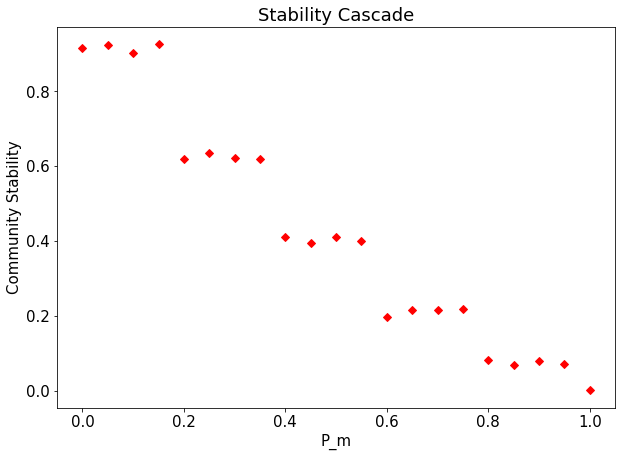

In [18]:
#Graphics
#Generate the canvas
fig=plt.figure("PLOT",figsize=(10,7))
s=fig.add_subplot(111)

#Get the lables right
plt.title("Stability Cascade",fontsize = 18)
plt.xlabel('P_m',fontsize=15)
plt.ylabel(r'Community Stability',fontsize=15)
plt.tick_params(axis='both', labelsize=15)

#Plot the Graph
plt.plot(f,Stability,'rD')

In [24]:
Stability

array(0.321)